# Introduction

In our analysis below we will read three dataframes regarding tens of thousands of sample points in a gold recovery process, representing nearly 80 measurements at various stages in the filtration.

After cleaning the data, we will explore how metal concentrations change depending on the purification stage. We must validate the feed particle size distributions between our training and test sets, as those reflect important chemical markers of overall material being worked with. Then we will also validate that the total substance concentration in each entry contains no statistical anomalies.

Finally, we will train some linear regression models to predict two metrics that are key in the success of the process: rougher recovery (a measure of gold recovery early in the process) and final recovery (the same measure at the end of the process). Our final evaluation will use the test set to evaluate how well these models predict these two metrics given novel data they were not trained on.

## Prepare the Data

### Initialize Libraries and First Looks at Dataframe

In [1]:
# Statistical libraries
import pandas as pd
from scipy import stats as st
import math
import numpy as np
from sklearn.metrics import *
from sklearn.utils import shuffle

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Graphing libraries
import plotly.express as px
from matplotlib import pyplot as plt

In [2]:
# Read Dataframe
df_train_raw = pd.read_csv('./datasets/gold_recovery_train.csv')
df_test_raw = pd.read_csv('./datasets/gold_recovery_test.csv')
df_full_raw = pd.read_csv('./datasets/gold_recovery_full.csv')

# Quick look
df_train_raw.info()
display(df_train_raw.head(3))
df_test_raw.info()
display(df_test_raw.head(3))
df_full_raw.info()
display(df_full_raw.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


### Ensure Correct Calculation of Rougher Output

In [3]:
# Check our work by predicting recovery values and comparing

''' 
RECOVERY FORMULA as FUNCTION: 

                C x (F - T)
    Recovery =  ----------- x 100%
                F x (C - T)
    
For finding the rougher concentrate recovery, the above letters mean:

    C = share of gold (au) in concentrate after flotation     =  rougher.output.concentrate_au
    F = share of gold (au) in feed before flotation           =  rougher.input.feed_au
    T = share of gold (au) in rougher tails after flotation   =  rougher.output.tail_au
'''

# Make prediction of rougher recovery with above formula
df_train_predicted_recovery_vals = (100 * df_train_raw['rougher.output.concentrate_au'] * 
    (df_train_raw['rougher.input.feed_au'] - df_train_raw['rougher.output.tail_au'])) / (df_train_raw['rougher.input.feed_au'] * 
    (df_train_raw['rougher.output.concentrate_au'] - df_train_raw['rougher.output.tail_au']))

# Calculate MAE, excluding NaN entries for now
nan_mask = df_train_raw['rougher.output.recovery'].isnull()
mae_rougher_recovery = mean_absolute_error(df_train_raw['rougher.output.recovery'][~nan_mask], df_train_predicted_recovery_vals[~nan_mask])
print('MAE for rougher recovery prediction using rougher concentrate formula:  {:.4f}'.format(mae_rougher_recovery))

# Compare against stored values in each dataframe
compare_df = pd.DataFrame()
compare_df['predicted_rougher_recovery'] = df_train_predicted_recovery_vals
compare_df['actual_rougher_recovery'] = df_train_raw['rougher.output.recovery']
display(compare_df.head(20))

MAE for rougher recovery prediction using rougher concentrate formula:  0.0000


,predicted_rougher_recovery,actual_rougher_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


The rougher recovery value appears to have been calculated according to the correct formula provided, with an MAE of 0.0000. We used only the training set to verify this calculation, since all OUTPUT features are omitted in the test set. We will look further into this difference in the next section.

### Compare Training and Test Set Features

In [4]:
# Get list of features for the two dataframes to compare
train_cols = df_train_raw.columns.tolist()
test_cols = df_test_raw.columns.tolist()

# Use NumPy's setdiff1d to see elements of test_cols not in train_cols
diff_cols = np.setdiff1d(train_cols, test_cols)
print('Features in training set omitted from the test set:')
print('')
display(pd.Series(diff_cols))

Features in training set omitted from the test set:



0                           final.output.concentrate_ag
1                           final.output.concentrate_au
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_au
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_au
11                primary_cleaner.output.concentrate_pb
12               primary_cleaner.output.concentrate_sol
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_au
15                       primary_cleaner.output.tail_pb
16                      primary_cleaner.output.tail_sol
17                      rougher.calculation.au_p

The bulk of the missing features in the test dataframe (as compared to the train dataframe) relate to output measures at each stage, including our target features. **This is troubling since we will be hard-pressed to evaluate the final models using the test dataset without matching target features.** We will need to find the 'final.output.recovery' and 'final.output.recovery' features in the complete dataframe and add them to the test dataframe.

In [5]:
# Do an inner merge 
df_test = df_test_raw.merge(df_full_raw[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')

In [6]:
# Quick look at data in training dataset
display(df_train_raw[diff_cols].head(10))

,final.output.concentrate_ag,final.output.concentrate_au,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_ag,final.output.tail_au,final.output.tail_pb,final.output.tail_sol,primary_cleaner.output.concentrate_ag,...,rougher.output.concentrate_sol,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_au,rougher.output.tail_pb,rougher.output.tail_sol,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_au,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol
0,6.055403,42.192020,9.889648,5.507324,70.541216,10.411962,2.143149,0.895447,16.904297,8.547551,...,28.029297,87.107763,5.008018,1.170244,0.508728,19.154297,14.500184,2.606185,4.694824,8.764648
1,6.029369,42.701629,9.968944,5.257781,69.266198,10.462676,2.224930,0.927452,16.634514,8.558743,...,28.067063,86.843261,4.955378,1.184827,0.536689,18.965234,14.265474,2.488248,4.592547,9.001494
2,6.055926,42.657501,10.213995,5.383759,68.116445,10.507046,2.257889,0.953716,16.208849,8.603505,...,27.454037,86.842308,4.843460,1.162562,0.546416,18.808533,14.115662,2.458187,4.624775,8.842896
3,6.047977,42.689819,9.977019,4.858634,68.347543,10.422762,2.146849,0.883763,16.532835,7.221879,...,27.341277,87.226430,4.655288,1.079755,0.542525,19.330200,13.732071,2.322062,4.482453,9.122857
4,6.148599,42.774141,10.142511,4.939416,66.927016,10.360302,2.055292,0.792826,16.525686,9.089428,...,27.041023,86.688794,4.552800,1.012642,0.515438,19.267422,14.079996,2.330448,4.470737,8.871028
5,6.482968,41.633678,10.049416,5.480257,69.465816,10.182708,1.918586,0.664118,16.999638,9.553724,...,26.898046,88.156912,4.397415,0.915835,0.491350,19.640269,13.615012,2.192127,4.286817,9.302669
6,6.533849,41.995316,10.058141,4.569100,69.300835,10.304598,2.058913,0.807342,16.723575,8.968869,...,27.063672,88.168065,4.478080,0.986248,0.518266,19.262491,13.597056,2.316720,4.487865,9.103047
7,6.130823,42.452727,9.935481,4.389813,70.230976,10.443288,2.143437,0.949346,16.689959,8.545238,...,27.231114,87.668336,4.728325,1.116110,0.548067,18.861866,13.177237,2.192197,4.432448,9.369209
8,5.834140,43.404078,10.071156,4.876389,69.688595,10.420140,2.209881,1.065453,17.201948,8.046686,...,27.404296,87.035862,4.764300,1.186780,0.599181,18.873082,13.487870,2.212084,4.608756,9.437044
9,5.687063,43.235220,9.980404,5.282514,70.279619,10.487013,2.209593,1.159805,17.483979,8.098985,...,27.497520,87.650868,4.667157,1.167140,0.615418,18.907179,13.209191,2.073737,4.550553,9.813732


There is nothing unusual about the underlying values and datatypes missing from the test dataframe -- they are all float64 and between 0 and 100 as they represent percentages. 

### Data Preprocessing -- Check Duplicates, Drop Extraneous Features, Clean Dataframes

First, we should check for duplicates in the 'dates' feature, and then the rows at large for the full set.

In [7]:
# Looking only at the full set, check for duplicates in the 'date' feature
print("Number of duplicated entries for 'date':", df_full_raw['date'].duplicated().sum())

# Looking only at the full set, check for duplicate rows
print("Number of duplicate rows:", df_full_raw.duplicated().sum())

Number of duplicated entries for 'date': 0
Number of duplicate rows: 0


We should remove the singular extraneous feature from our training set that we do not want our model to be trained on:

In [8]:
# Drop the date column
df = df_full_raw.drop(['date'], axis=1)
df_train = df_train_raw.drop(['date'], axis=1)
df_test = df_test.drop(['date'], axis=1)

Finally, we need to check for null values and remove entries with null values, as filling with mean or median values is not appropriate with how many target features exist and due to the step-by-step relationship between each step in the extraction process.

In [9]:
# Drop all rows with missing values, resetting index
df = df.dropna()
df_train = df_train.dropna()
df_test_final = df_test.dropna()

# Display row count
print(f'Number of rows in complete dataframe = {df.shape[0]}.')

Number of rows in complete dataframe = 16094.


We dropped a large portion of our dataset -- 6,622 out of our total of 22,716 entries, but every entry has an accurate reading for every feature and step in the extraction process.

We will now move on to an analysis step prior to our linear regression.

## Analyze the data

### Track Mean Metal Concentration by Purification Stage

In [10]:
# Each stage's metal output concentration can be found in the below features:
#     [stage].output.concentrate_au
#     [stage].output.concentrate_ag
#     [stage].output.concentrate_pb
stage_names = ['rougher', 'primary_cleaner', 'final'] # There is no concentrate data for the secondary_cleaner stage
metal_names = ['Gold', 'Silver', 'Lead']
feature_term = ['.output.concentrate_au', '.output.concentrate_ag', '.output.concentrate_pb']

# Aggregate data in long form for sake of bar graph analysis
metal_data = []
for i in range(len(stage_names)):
    for j in range(len(metal_names)):
        col_name = stage_names[i] + feature_term[j]
        metal_data.append([stage_names[i], metal_names[j], df[col_name].mean()])
        
# Create new dataframe for tracking mean metal concentration changes 
metal_columns = ['stage', 'metal', 'mean_concentration']
df_metals = pd.DataFrame(data=metal_data, columns=metal_columns)

# First plot is a bar graph tracking three metal concentrations by stage
fig1 = px.bar(df_metals, x='stage', y='mean_concentration', 
            labels={'stage': 'Stage', 'metal': 'Metal', 'mean_concentration': 'Average Percentage Concentration'},
            color='metal', 
            text='metal',
            title='Average Metal Concentration By Purification Stage')
fig1.show()

As expected, the Gold concentration increases from 20% in the roughest feed to 50% after the final filtration stage. What is surprising is that Lead increases in average concentration. This indicates that as material is stripped away at each stage, the amount of lead removed is lower than other components, leaving the concentration of remaining lead to increase in some samples. Silver, on the other hand, is effectively stripped away, being reduced from an average concentration of 12.08% to 5.19%.

### Validate the Feed Particle Size Between Train and Test Sets

The concentrations are simply percentages of the material being worked with. The chemical and mechanical processes involved in purification will yield different changes between the purification stages dependent on the quantity of material passed through -- the feed particle size. Therefore, we must validate that the distributions of feed particle size are similar in the train and test sets.

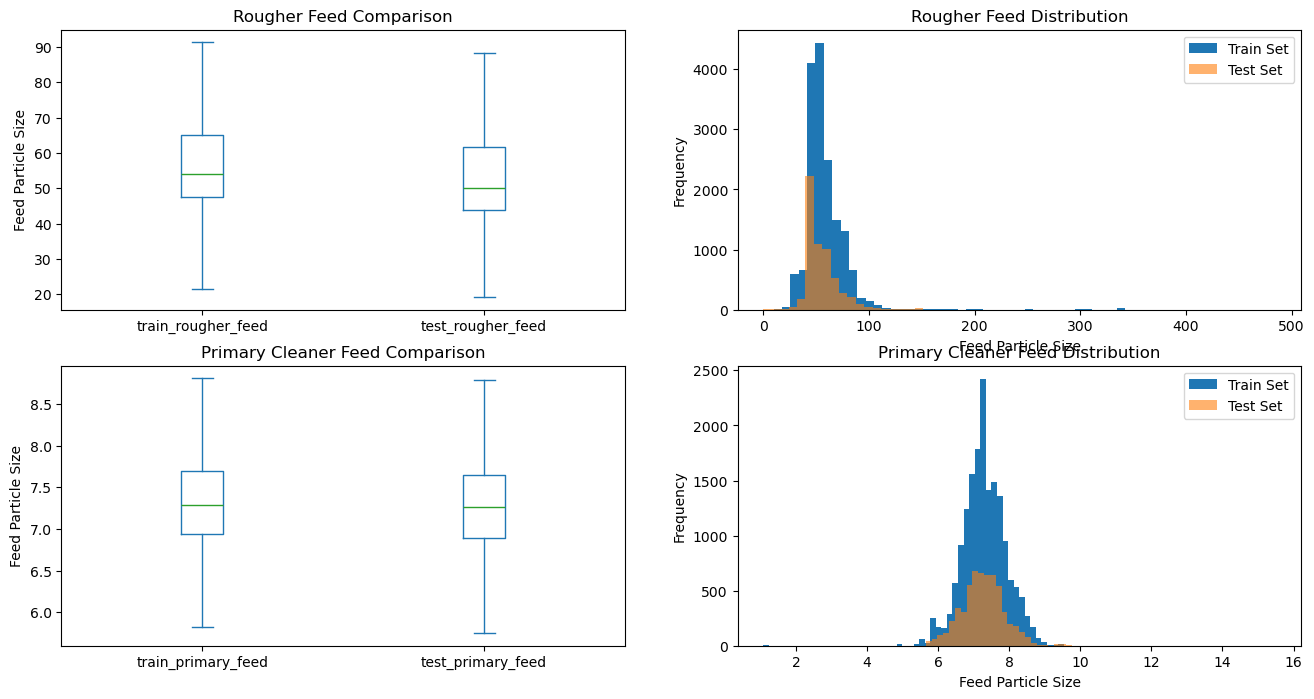

P value for rougher feed distribution equals 2.827914509738783e-14.
We can reject the null hypothesis for rougher feed distribution.
P value for primary cleaner feed distribution equals 0.0004916543727368148.
We can reject the null hypothesis for primary cleaner feed distribution.


In [11]:
# The below dataframe is for graphing purposes only and is not meant to represent meaningful row-wise data
df_train_vs_test = pd.DataFrame({'train_rougher_feed': df_train_raw['rougher.input.feed_size'],
                                 'test_rougher_feed': df_test_raw['rougher.input.feed_size'],
                                 'train_primary_feed': df_train_raw['primary_cleaner.input.feed_size'],
                                 'test_primary_feed': df_test_raw['primary_cleaner.input.feed_size']})

# Compare feed particle size
fig, axs = plt.subplots(2, 2, figsize=(16,8))
axs[0, 0].clear()
df_train_vs_test[['train_rougher_feed', 'test_rougher_feed']].plot(kind='box', ax=axs[0, 0], showfliers=False)
axs[0, 0].set_title('Rougher Feed Comparison')
axs[0, 0].set_ylabel('Feed Particle Size')

axs[0, 1].clear()
df_train_vs_test['train_rougher_feed'].plot(kind='hist', ax=axs[0, 1], bins=60)
df_train_vs_test['test_rougher_feed'].plot(kind='hist', ax=axs[0, 1], bins=60, alpha=0.6)
axs[0, 1].set_title('Rougher Feed Distribution')
axs[0, 1].set_xlabel('Feed Particle Size')
axs[0, 1].legend(['Train Set', 'Test Set'])

axs[1, 0].clear()
df_train_vs_test[['train_primary_feed', 'test_primary_feed']].plot(kind='box', ax=axs[1, 0], showfliers=False)
axs[1, 0].set_title('Primary Cleaner Feed Comparison')
axs[1, 0].set_ylabel('Feed Particle Size')

axs[1, 1].clear()
df_train_vs_test['train_primary_feed'].plot(kind='hist', ax=axs[1, 1], bins=60)
df_train_vs_test['test_primary_feed'].plot(kind='hist', ax=axs[1, 1], bins=60, alpha=0.6)
axs[1, 1].set_title('Primary Cleaner Feed Distribution')
axs[1, 1].set_xlabel('Feed Particle Size')
axs[1, 1].legend(['Train Set', 'Test Set'])
plt.show()

''' 
For thoroughness, do a one-sided t-test for comparison of means with the below hypotheses:

     Ho = "The rougher feed distribution mean for the training set is not significantly different than the test set mean"
     Ha = "The rougher feed distribution mean for the training set is significantly different than the test set mean"

     Ho = "The primary cleaner feed distribution mean for the training set is not significantly different than the test set mean"
     Ha = "The primary cleaner feed distribution mean for the training set is significantly different than the test set mean"
     
Test the hypotheses under strict critical significance
'''
alpha = 0.01
rougher_results = st.ttest_ind(df_train_vs_test['train_rougher_feed'], 
                               df_train_vs_test['test_rougher_feed'],
                               equal_var=True,
                               nan_policy='omit')
primary_results = st.ttest_ind(df_train_vs_test['train_primary_feed'], 
                               df_train_vs_test['test_primary_feed'], 
                               equal_var=True,
                               nan_policy='omit')

# Print
print(f"P value for rougher feed distribution equals {rougher_results.pvalue}.")
if (rougher_results.pvalue < alpha):
    print('We can reject the null hypothesis for rougher feed distribution.')
else:
    print('We cannot reject the null hypothesis for rougher feed distribution.')
    
print(f"P value for primary cleaner feed distribution equals {primary_results.pvalue}.")
if (primary_results.pvalue < alpha):
    print('We can reject the null hypothesis for primary cleaner feed distribution.')
else:
    print('We cannot reject the null hypothesis for primary cleaner feed distribution.')

While the distributions for the feed particle sizes appear equivalent, their population means are significantly different. While any difference should be suspect given the first graph for each dataset, we will assuage any concern by utilizing cross-validation to create multiple balanced test and training sets.

Our final check is to look at the total concentrations of all substances and consider anomalies before moving on to model training.

### Validate Total Substance Concentrations

#### Determine Total Concentrations for Each Data Sample

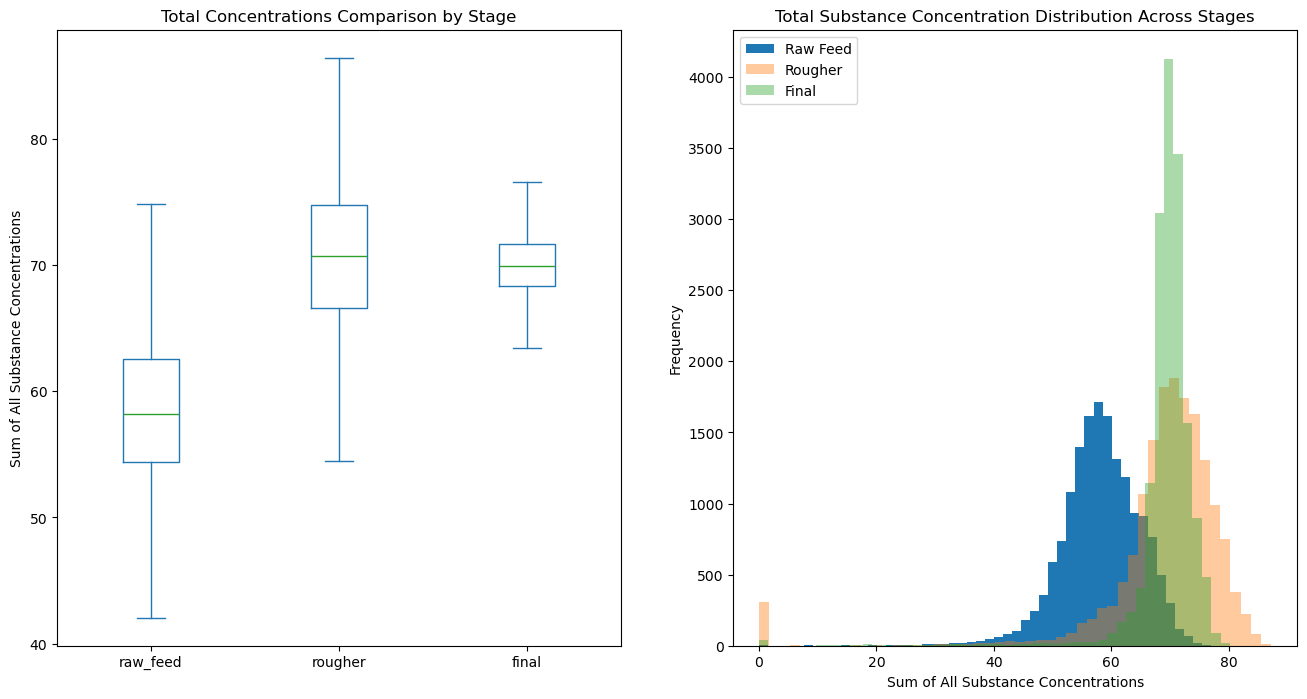

In [12]:
## RAW FEED CONCENTRATION FEATURE NAMES
# Gold     :   rougher.input.feed_au  
# Silver   :   rougher.input.feed_ag 
# Solution :   rougher.input.feed_sol
# Lead     :   rougher.input.feed_pb

## ROUGHER CONCENTRATION FEATURE NAMES
# Gold     :   rougher.output.concentrate_au  
# Silver   :   rougher.output.concentrate_ag 
# Solution :   rougher.output.concentrate_sol
# Lead     :   rougher.output.concentrate_pb

## FINAL CONCENTRATE FEATURE NAMES
# Gold     :   final.output.concentrate_au  
# Silver   :   final.output.concentrate_ag 
# Solution :   final.output.concentrate_sol
# Lead     :   final.output.concentrate_pb

substance_feature_names = ['gold', 'silver', 'solution', 'lead']
substance_display_names = ['Gold', 'Silver', 'Solution', 'Lead']
raw_feed_feature_names = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_sol', 'rougher.input.feed_pb']
rougher_feature_names = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_pb']
final_feature_names = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_sol', 'final.output.concentrate_pb']

# Helper function for renaming columns based on the above feature arrays. This is not necessary but is the safest practice.
def arrays_to_dict(array_1, array_2):
    return_dict = {}
    for key, val in zip(array_1, array_2):
        return_dict.setdefault(key, []).append(val)
    return return_dict

# Create the three dataframes for storing the above data
df_raw_feed_concentrations = df[raw_feed_feature_names].rename(arrays_to_dict(raw_feed_feature_names, substance_feature_names))
df_rougher_concentrations = df[rougher_feature_names].rename(arrays_to_dict(rougher_feature_names, substance_feature_names))
df_final_concentrations = df[final_feature_names].rename(arrays_to_dict(final_feature_names, substance_feature_names))

# Create new feature representing total concentration that simply sums all other columns
df_raw_feed_concentrations['total'] = df_raw_feed_concentrations.apply(sum, axis=1)
df_rougher_concentrations['total'] = df_rougher_concentrations.apply(sum, axis=1)
df_final_concentrations['total'] = df_final_concentrations.apply(sum, axis=1)

# Create new dataframe for graphing purposes comparing new feature created above between all three stages
df_total_concentrations = pd.concat([df_raw_feed_concentrations['total'], 
                                     df_rougher_concentrations['total'],
                                     df_final_concentrations['total']], axis='columns')
df_total_concentrations.columns = ['raw_feed', 'rougher', 'final']

# Graph distributions of the above
fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].clear()
df_total_concentrations.plot(kind='box', ax=axs[0], showfliers=False)
axs[0].set_title('Total Concentrations Comparison by Stage')
axs[0].set_ylabel('Sum of All Substance Concentrations')

axs[1].clear()
df_total_concentrations['raw_feed'].plot(kind='hist', ax=axs[1], bins=50)
df_total_concentrations['rougher'].plot(kind='hist', ax=axs[1], bins=50, alpha=0.4)
df_total_concentrations['final'].plot(kind='hist', ax=axs[1], bins=50, alpha=0.4)
axs[1].set_title('Total Substance Concentration Distribution Across Stages')
axs[1].set_xlabel('Sum of All Substance Concentrations')
axs[1].legend(['Raw Feed', 'Rougher', 'Final'])

We have some dangerous outliers around the 0 mark. We should assert that if a total distribution is lower than a certain low value, we drop the data entry. We should drop those entries and save the result to a new, final dataframe to pass to our models.

In [13]:
# We must remove entries with such low total substance concentrations from two of our main dataframes (df_train, df)

th = 5 # This will preserve entries with total concentrations at every stage equal to or above this number

# We will create new dataframes to filter the training set, just as we've done above for the main dataset
# Create the three dataframes for storing the above data
df_train_raw_feed_concentrations = df_train[raw_feed_feature_names].rename(arrays_to_dict(raw_feed_feature_names, substance_feature_names))
df_train_rougher_concentrations = df_train[rougher_feature_names].rename(arrays_to_dict(rougher_feature_names, substance_feature_names))
df_train_final_concentrations = df_train[final_feature_names].rename(arrays_to_dict(final_feature_names, substance_feature_names))

# Create new feature representing total concentration that simply sums all other columns
df_train_raw_feed_concentrations['total'] = df_train_raw_feed_concentrations.apply(sum, axis=1)
df_train_rougher_concentrations['total'] = df_train_rougher_concentrations.apply(sum, axis=1)
df_train_final_concentrations['total'] = df_train_final_concentrations.apply(sum, axis=1)

# The indices of the concentration data points (rows of the above dataframes) are in the same order 
#   as the original dataframe after a concatenation. It is safest to do a logical operation instead of 
#   an index-based or query-based operation to filter the original dataframe.

df_train_filter_boolean = (df_train_raw_feed_concentrations['total'] >= th) & (
                    df_train_rougher_concentrations['total'] >= th) & (
                    df_train_final_concentrations['total'] >= th)
df_train_final = df_train[df_train_filter_boolean]
print(f'Removed {(~df_train_filter_boolean).sum()} rows out of {df_train.shape[0]} rows from the training dataframe.')

df_filter_boolean = (df_raw_feed_concentrations['total'] >= th) & (
                    df_rougher_concentrations['total'] >= th) & (
                    df_final_concentrations['total'] >= th)
df_final = df[df_filter_boolean]
print(f'Removed {(~df_filter_boolean).sum()} rows out of {df.shape[0]} rows from the main dataframe.')

Removed 239 rows out of 11017 rows from the training dataframe.
Removed 347 rows out of 16094 rows from the main dataframe.


## Build the Model

### Calculating final sMAPE value

The sMAPE value is the symmetric Mean Absolute Percentage Error. The below sMAPE function takes the absolute difference of each real observation and model prediction and divides that by the absolute mean of those two values. It then represents that as a percentage and takes the mean across all observations.

Our final sMAPE is a combination of the sMAPE observed for the rougher concentration recovery and the sMAPE observed for the final concentration recovery, weighted at .25 and .75 respectively.

In [14]:
'''
sMAPE FORMULA as FUNCTION:

                        | y - ŷ |
    sMAPE = MEAN ( ---------------------  x 100%  )
                   ( | y | - | ŷ | ) / 2
'''

def smape(target, prediction):
    accum_array = []
    for i in range(0, len(target)):
        accum_array.append(100 * abs(target[i] - prediction[i]) / ((abs(target[i]) + abs(prediction[i])) / 2))
    return pd.Series(accum_array).mean()

def final_smape(target_rougher, prediction_rougher, target_final, prediction_final):
    return .25 * smape(target_rougher, prediction_rougher) + .75 * smape(target_final, prediction_final)

### Training and Evaluating the Models

#### Identify Features and Target for Training

In [15]:
# We will be cross-validating using the training dataset.
# We save the test dataset to evaluate our best model in the final step below.
target_features = ['rougher.output.recovery', 'final.output.recovery']
features = df_train_final.drop(diff_cols, axis=1) # This drops the features not included in the test set to avoid training the model on data it won't be tested on
target_rougher = df_train_final[target_features[0]]
target_final = df_train_final[target_features[1]]

# Prepare the test features and target for our final evaluation step
test_features = df_test_final.drop(target_features, axis=1)
target_test_rougher = df_test_final[target_features[0]]
target_test_final = df_test_final[target_features[1]]

#### Build and Train Models Using Cross-validation

In [16]:
# We are considering a sample size of about 1/5 of the set
sample_size = int(len(features)/5)
best_rougher_model = []
best_final_model = []
best_sMAPE = 999999

for i in range(0, len(features), sample_size):
    # Find a sample index location and split index list around that location, then split data
    sample_index = math.floor(i+sample_size)
    if sample_index >= len(features):
        break
    valid_indexes = list(range(i,sample_index))
    train_indexes = list(range(0, i)) + list(range((sample_index), len(features)))
    features_train = features.iloc[train_indexes]
    features_valid = features.iloc[valid_indexes]
    target_rougher_train = target_rougher.iloc[train_indexes]
    target_rougher_valid = target_rougher.iloc[valid_indexes]
    target_final_train = target_final.iloc[train_indexes]
    target_final_valid = target_final.iloc[valid_indexes]
    
    # One model to predict rougher concentrate recovery ('rougher.output.recovery')
    rougher_model = LinearRegression()
    rougher_model = rougher_model.fit(features_train, target_rougher_train)
    rougher_predictions = rougher_model.predict(features_valid)
    
    # One model to predict final concentrate recovery ('final.output.recovery')
    final_model = LinearRegression()
    final_model = final_model.fit(features_train, target_final_train)
    final_predictions = final_model.predict(features_valid)
    
    # Calculate final sMAPE
    sMAPE = final_smape(target_rougher_valid.to_list(), rougher_predictions, target_final_valid.to_list(), final_predictions)
    
    # Save best model
    if sMAPE < best_sMAPE:
        best_rougher_model = rougher_model
        best_final_model = final_model

#### Evaluate Models + Visualize Tests and Predictions

Best-performing model had a final sMAPE of 9.135555321155797.
True final recovery averages around 68.65760229535077, while the true rougher recovery averages around 85.1322324065655


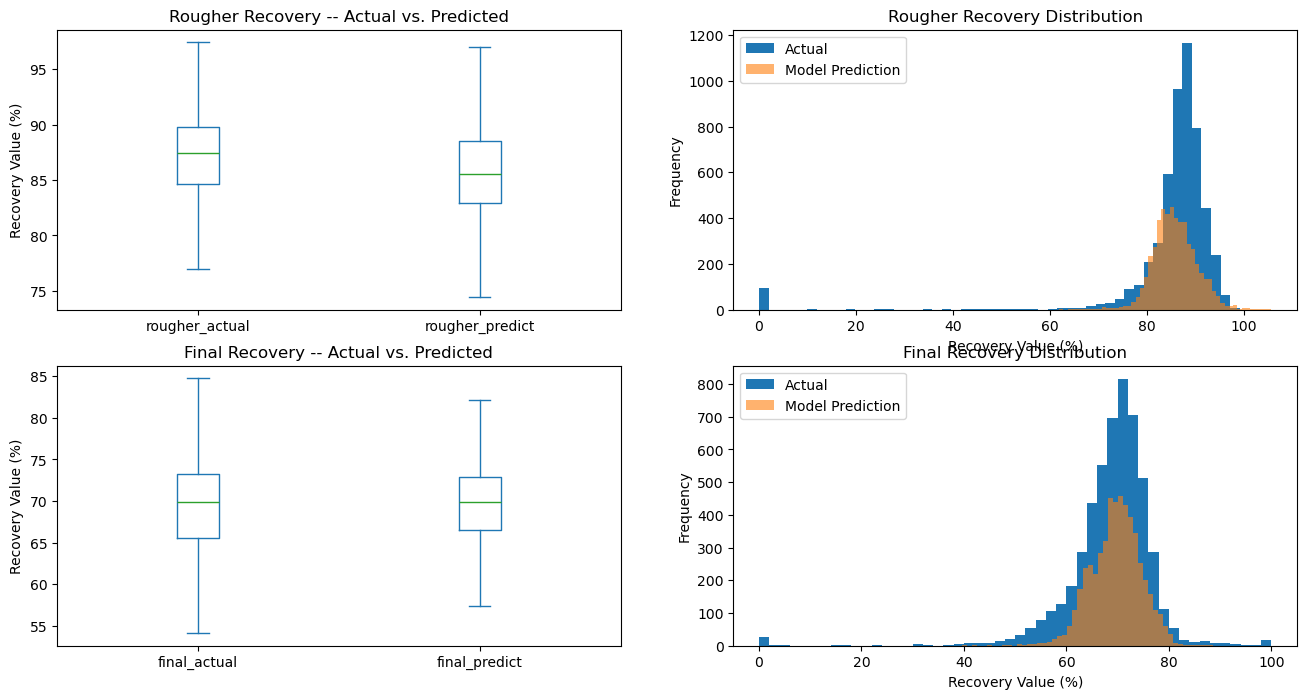

In [17]:
# Make predictions based on test dataset
rougher_predict = best_rougher_model.predict(test_features)
final_predict = best_final_model.predict(test_features)
best_final_sMAPE = final_smape(target_test_rougher.to_list(), rougher_predict, target_test_final.to_list(), final_predict)
print(f'Best-performing model had a final sMAPE of {best_final_sMAPE}.')

# Dataframe for graphing combining all targets and predictions
df_recovery = pd.DataFrame({'rougher_actual': target_test_rougher.to_list(),
                            'rougher_predict': rougher_predict,
                            'final_actual': target_test_final.to_list(),
                            'final_predict': final_predict})
rougher_actual_mean = df_recovery['rougher_actual'].mean()
final_actual_mean = df_recovery['final_actual'].mean()
print(f'True final recovery averages around {final_actual_mean}, while the true rougher recovery averages around {rougher_actual_mean}')

# Compare predictions for recovery
fig, axs = plt.subplots(2, 2, figsize=(16,8))
axs[0, 0].clear()
df_recovery[['rougher_actual', 'rougher_predict']].plot(kind='box', ax=axs[0, 0], showfliers=False)
axs[0, 0].set_title('Rougher Recovery -- Actual vs. Predicted')
axs[0, 0].set_ylabel('Recovery Value (%)')

axs[0, 1].clear()
df_recovery['rougher_actual'].plot(kind='hist', ax=axs[0, 1], bins=50)
df_recovery['rougher_predict'].plot(kind='hist', ax=axs[0, 1], bins=50, alpha=0.6)
axs[0, 1].set_title('Rougher Recovery Distribution')
axs[0, 1].set_xlabel('Recovery Value (%)')
axs[0, 1].legend(['Actual', 'Model Prediction'])

axs[1, 0].clear()
df_recovery[['final_actual', 'final_predict']].plot(kind='box', ax=axs[1, 0], showfliers=False)
axs[1, 0].set_title('Final Recovery -- Actual vs. Predicted')
axs[1, 0].set_ylabel('Recovery Value (%)')

axs[1, 1].clear()
df_recovery['final_actual'].plot(kind='hist', ax=axs[1, 1], bins=50)
df_recovery['final_predict'].plot(kind='hist', ax=axs[1, 1], bins=50, alpha=0.6)
axs[1, 1].set_title('Final Recovery Distribution')
axs[1, 1].set_xlabel('Recovery Value (%)')
axs[1, 1].legend(['Actual', 'Model Prediction'])
plt.show()

The final recovery is distributed at about 16.5% lower than the rougher recovery, but both are roughly bell-shaped around their means. The models were able to predict this difference and keep the final sMAPE in the single-digits.

It is worth noting that the model predicting the rougher recovery had a small percentage of predictions above 100, which is invalid for a percentage data type. That model also had a slightly more right-skewed distribution. Clearly, there were certain features in the model's calculation which were over-weighted and skewed recovery higher than it should have been.

# Conclusion

In our above analysis we read three dataframes regarding tens of thousands of sample points in a gold recovery process, representing nearly 80 measurements at various stages in the filtration. 

After cleaning the data, we analyzed how metal concentrations changed depending on the purification stage and found: (1) lead concentration does not lower and often even increases (relative to lower total particle counts); (2) silver concentration consistently lowers; (3) gold concentration more than doubles by the end of the process. We validated first that the feed particle size distributions are equivalent between the training and test sets, and second that the total substance concentration was statistically valid, removing near-zero concentrations.

Finally, we built some models to predict rougher recovery (a measure of gold recovery early in the process) and final recovery (the same measure at the end of the process). Our final evaluation showed that the distributions were equivalent and the models could distinguish rougher recovery from final recovery.